# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Batch Normalization

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_BN(nn.Module):
    def __init__(self):
        super(CustomResNet_BN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch Normalization
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.bn4(x)  # Apply Batch Normalization
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_BN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_BN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.1024, Train Accuracy: 36.71%, Val Loss: 2.0392, Val Accuracy: 42.78%
Epoch: 2, Train Loss: 1.9552, Train Accuracy: 51.36%, Val Loss: 1.9874, Val Accuracy: 47.34%
Epoch: 3, Train Loss: 1.8800, Train Accuracy: 58.90%, Val Loss: 1.8805, Val Accuracy: 58.62%
Epoch: 4, Train Loss: 1.8312, Train Accuracy: 63.76%, Val Loss: 1.8556, Val Accuracy: 61.10%
Epoch: 5, Train Loss: 1.7974, Train Accuracy: 67.19%, Val Loss: 1.8317, Val Accuracy: 63.36%
Epoch: 6, Train Loss: 1.7761, Train Accuracy: 69.17%, Val Loss: 1.7986, Val Accuracy: 66.46%
Epoch: 7, Train Loss: 1.7582, Train Accuracy: 70.86%, Val Loss: 1.7959, Val Accuracy: 66.78%
Epoch: 8, Train Loss: 1.7379, Train Accuracy: 72.83%, Val Loss: 1.7675, Val Accuracy: 69.58%
Epoch: 9, Train Loss: 1.7257, Train Accuracy: 74.03%, Val Loss: 1.7642, Val Accuracy: 69.60%
Epoch: 10, Train Loss: 1.7180, Train Accuracy: 74.68%, Val Loss: 1.7488, Val Accuracy: 71.70%
Epoch: 11, Train Loss: 1.7075, Train Accuracy: 75.80%, Val Loss: 1.75

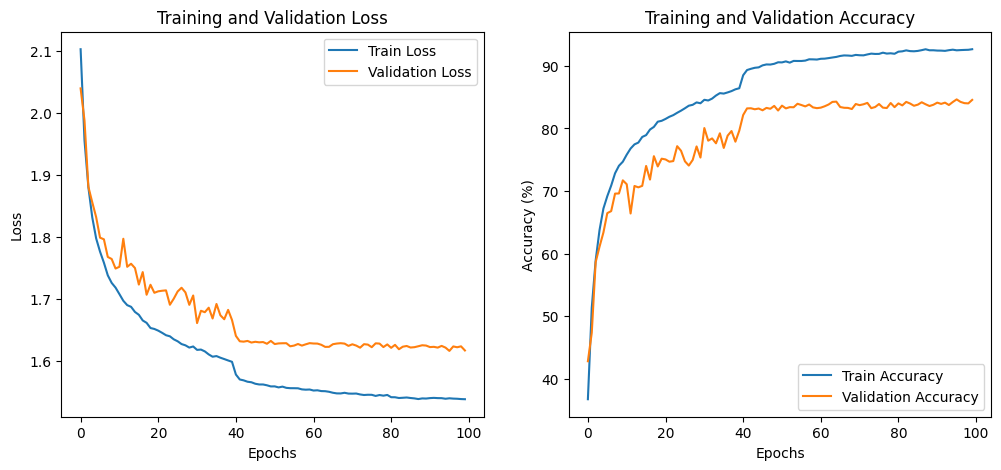

Best Validation Accuracy: 84.64%
Test Accuracy of the final model: 85.67%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_BN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1mj8hmMaKlgtabkbcj6LIhq7AbRxPiGVE"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_BN(nn.Module):
    def __init__(self):
        super(CustomResNet_BN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch Normalization
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.bn4(x)  # Apply Batch Normalization
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet_BN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_BN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_BN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'match_conv1', 'match_conv2', 'match_conv3', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [18]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 94.02it/s] 


### Calc SI

In [19]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 376.10it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7342.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7111.40it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7279.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7289.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7651.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7460.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7219.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7484.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7609.40it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7659.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7505.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7065.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8022.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7254.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7051.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7121.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6468.70it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6239.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6967.28it/s]


In [20]:
si_layer_train

[('conv1', 0.21122223138809204),
 ('bn1', 0.21122223138809204),
 ('elu1', 0.2118888944387436),
 ('conv2', 0.19733333587646484),
 ('bn2', 0.19733333587646484),
 ('elu2', 0.1940000057220459),
 ('maxpool1', 0.2935555577278137),
 ('resblock1', 0.38499999046325684),
 ('maxpool2', 0.4633333384990692),
 ('conv3', 0.4055555462837219),
 ('bn3', 0.4055555462837219),
 ('elu3', 0.4082222282886505),
 ('maxpool3', 0.6155555844306946),
 ('conv4', 0.5605555772781372),
 ('bn4', 0.5605555772781372),
 ('elu4', 0.5789999961853027),
 ('resblock2', 0.8117777705192566),
 ('avgpool', 0.8797777891159058),
 ('flatten', 0.8797777891159058),
 ('softmax', 0.9045555591583252)]

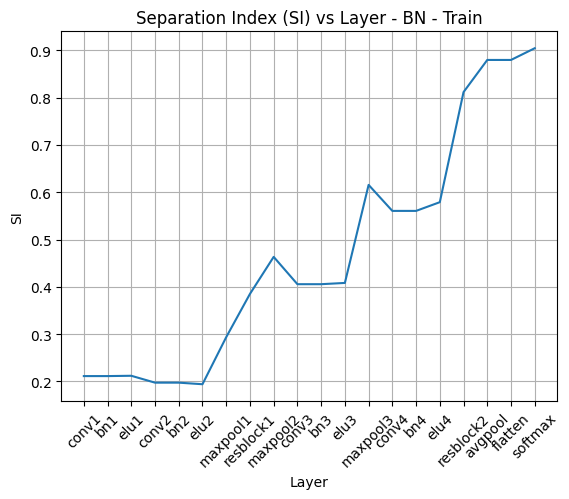

In [21]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - BN - Train')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [22]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 878.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4196.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4190.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4113.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4326.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4429.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3066.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3090.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3767.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4324.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4366.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4803.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4096.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3481.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3313.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3132.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4064.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2177.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2947.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4071.35it/s]


[('conv1', 0.34744444489479065), ('bn1', 0.34744444489479065), ('elu1', 0.362888902425766), ('conv2', 0.3723333477973938), ('bn2', 0.3723333477973938), ('elu2', 0.3807777762413025), ('maxpool1', 0.4485555589199066), ('resblock1', 0.5762222409248352), ('maxpool2', 0.6091111302375793), ('conv3', 0.5784444212913513), ('bn3', 0.5784444212913513), ('elu3', 0.5823333263397217), ('maxpool3', 0.6503333449363708), ('conv4', 0.6148889064788818), ('bn4', 0.6148889064788818), ('elu4', 0.6196666955947876), ('resblock2', 0.9001111388206482), ('avgpool', 0.9227777719497681), ('flatten', 0.9227777719497681), ('softmax', 0.9319999814033508)]


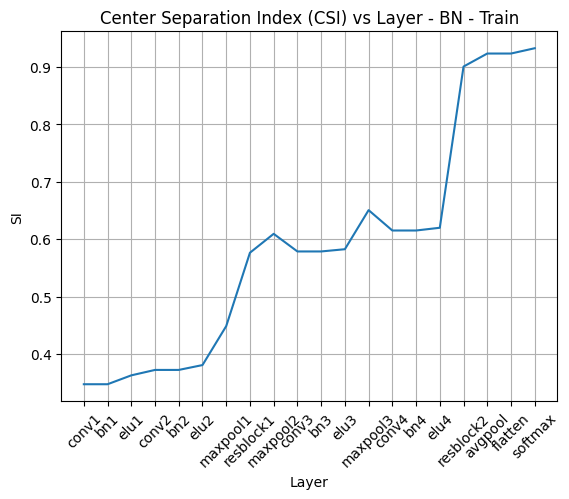

In [24]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - BN - Train')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.98it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 223.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5256.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5037.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 1393.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4983.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5069.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5271.43it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5619.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5570.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5269.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4951.95it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5245.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4595.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5154.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4620.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5169.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5256.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5027.13it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4936.41it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4993.22it/s]


In [10]:
si_layer_val

[('conv1', 0.20479999482631683),
 ('bn1', 0.20479999482631683),
 ('elu1', 0.2011999934911728),
 ('conv2', 0.19119998812675476),
 ('bn2', 0.19119998812675476),
 ('elu2', 0.1899999976158142),
 ('maxpool1', 0.2624000012874603),
 ('resblock1', 0.33739998936653137),
 ('maxpool2', 0.42419999837875366),
 ('conv3', 0.3619999885559082),
 ('bn3', 0.3619999885559082),
 ('elu3', 0.3675999939441681),
 ('maxpool3', 0.5727999806404114),
 ('conv4', 0.5187999606132507),
 ('bn4', 0.5187999606132507),
 ('elu4', 0.5363999605178833),
 ('resblock2', 0.793999969959259),
 ('avgpool', 0.870199978351593),
 ('flatten', 0.870199978351593),
 ('softmax', 0.9101999998092651)]

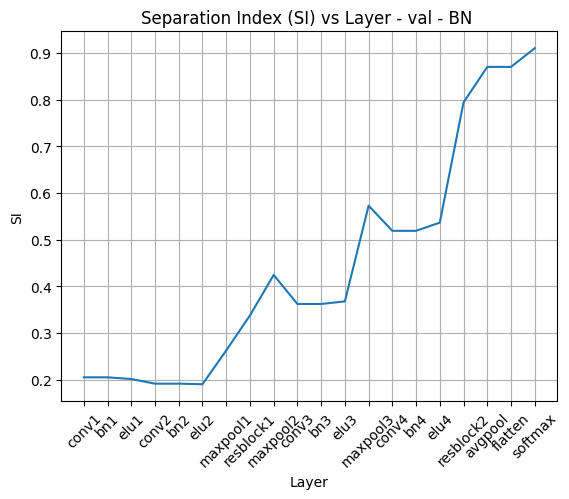

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - BN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 436.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3283.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3175.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3292.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3370.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3209.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3123.86it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3181.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3024.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3520.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3152.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3137.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3048.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3193.63it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3066.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3490.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3214.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1170.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2323.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3314.78it/s]


[('conv1', 0.3522000014781952), ('bn1', 0.3522000014781952), ('elu1', 0.36899998784065247), ('conv2', 0.3879999816417694), ('bn2', 0.3879999816417694), ('elu2', 0.3937999904155731), ('maxpool1', 0.4667999744415283), ('resblock1', 0.6011999845504761), ('maxpool2', 0.6258000135421753), ('conv3', 0.6028000116348267), ('bn3', 0.6028000116348267), ('elu3', 0.6037999987602234), ('maxpool3', 0.6621999740600586), ('conv4', 0.6233999729156494), ('bn4', 0.6233999729156494), ('elu4', 0.6319999694824219), ('resblock2', 0.8977999687194824), ('avgpool', 0.9257999658584595), ('flatten', 0.9257999658584595), ('softmax', 0.9389999508857727)]


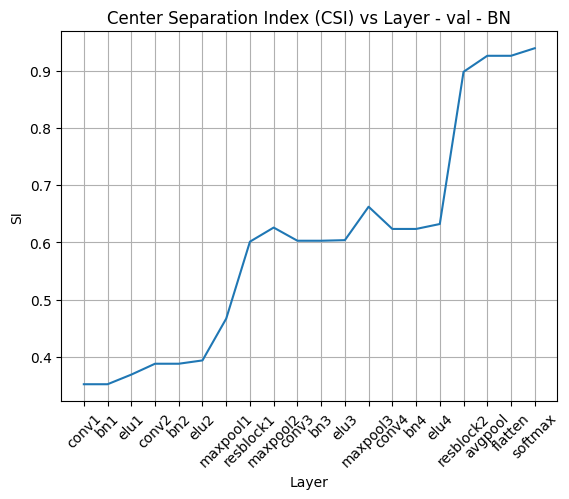

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 27.26it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 358.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7546.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7980.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7801.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7764.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7892.93it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7793.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7848.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8103.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7787.42it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7495.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7884.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7952.79it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6962.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8266.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7973.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7460.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7199.29it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7549.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6795.70it/s]


In [10]:
si_layer_test

[('conv1', 0.2223999947309494),
 ('bn1', 0.2223999947309494),
 ('elu1', 0.22119998931884766),
 ('conv2', 0.21529999375343323),
 ('bn2', 0.21529999375343323),
 ('elu2', 0.2141999900341034),
 ('maxpool1', 0.2938999831676483),
 ('resblock1', 0.3933999836444855),
 ('maxpool2', 0.4730999767780304),
 ('conv3', 0.4220999777317047),
 ('bn3', 0.4220999777317047),
 ('elu3', 0.43359997868537903),
 ('maxpool3', 0.602899968624115),
 ('conv4', 0.5584999918937683),
 ('bn4', 0.5584999918937683),
 ('elu4', 0.5776999592781067),
 ('resblock2', 0.7633999586105347),
 ('avgpool', 0.7883999943733215),
 ('flatten', 0.7883999943733215),
 ('softmax', 0.8100000023841858)]

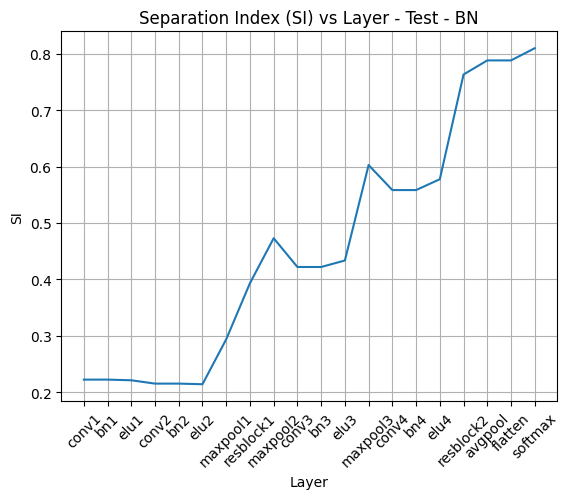

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 680.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4300.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4555.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4200.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4241.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4668.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3071.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3221.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4239.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4588.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4842.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 5063.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4104.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3122.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3265.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3212.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4325.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4246.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4380.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4417.85it/s]


[('conv1', 0.3554999828338623), ('bn1', 0.3554999828338623), ('elu1', 0.36980000138282776), ('conv2', 0.3804999887943268), ('bn2', 0.3804999887943268), ('elu2', 0.3862999975681305), ('maxpool1', 0.45319998264312744), ('resblock1', 0.5644999742507935), ('maxpool2', 0.6032999753952026), ('conv3', 0.5697999596595764), ('bn3', 0.5697999596595764), ('elu3', 0.5742999911308289), ('maxpool3', 0.6448000073432922), ('conv4', 0.612500011920929), ('bn4', 0.612500011920929), ('elu4', 0.6197999715805054), ('resblock2', 0.8276999592781067), ('avgpool', 0.8454999923706055), ('flatten', 0.8454999923706055), ('softmax', 0.8567999601364136)]


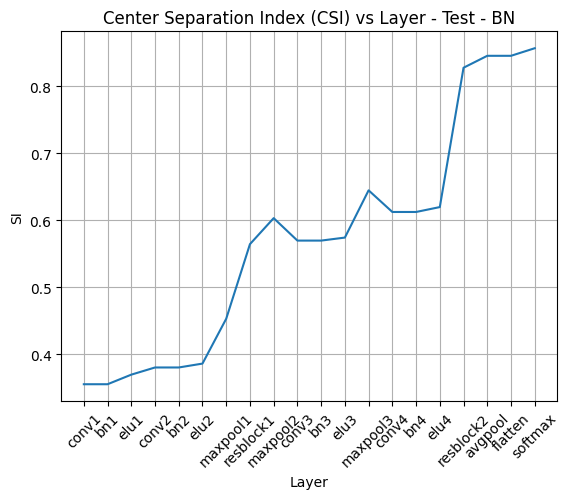

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()